In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as sch

from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit

In [2]:
### SYNTHETIC CORRELATED DATA GENERATION ###

np.random.seed(33)

n_features = 50
n_samples = 4_000

r = np.random.randint(-2,10, (n_features,n_features))
r = np.dot(r, r.T)

x = np.random.normal(0,1, (n_features,n_samples))
c = np.linalg.cholesky(r)

X = pd.DataFrame(
    np.dot(c, x).T, columns=[f"feat_{c+1}" for c in range(n_features)]
)

corr_mat = pairwise_distances(X.T, metric='correlation')

X.shape, corr_mat.shape

((4000, 50), (50, 50))

<AxesSubplot:ylabel='Density'>

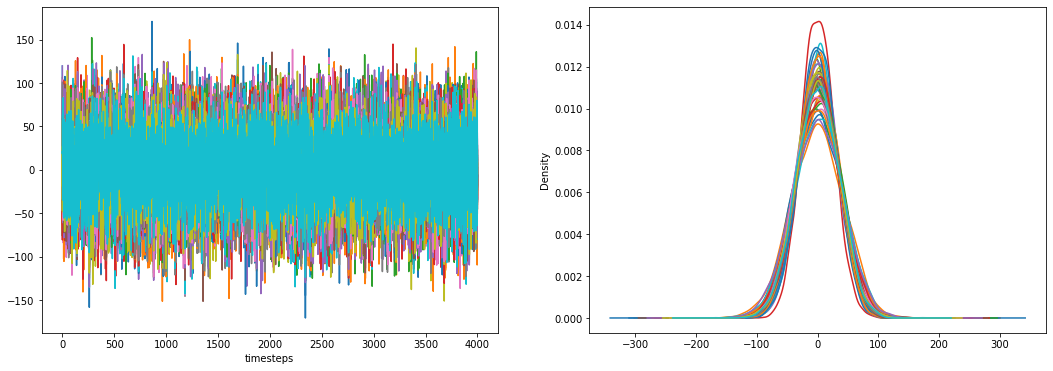

In [3]:
### PLOT SERIES DISTRIBUTIONS ###

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
X.plot(legend=False, xlabel='timesteps', ax=plt.gca())
plt.subplot(1,2,2)
X.plot(kind='density', legend=False, ax=plt.gca())

Text(0.5, 68.09375, 'series')

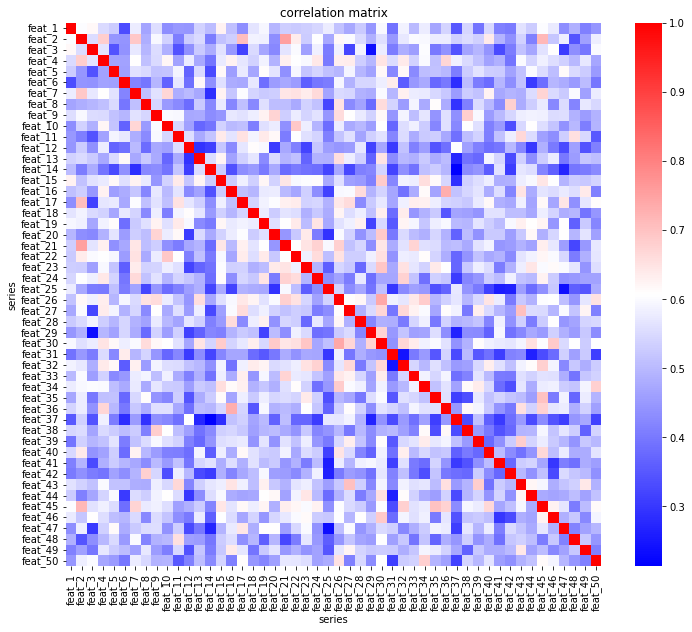

In [4]:
### PLOT SERIES CORRELATIONS ###

plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=False, cmap='bwr')
plt.title('correlation matrix')
plt.ylabel('series'); plt.xlabel('series')

In [5]:
### MANUALLY INSERT ANOMALOUS PERIOD ###

n_samples_change = 400
_ = np.random.randint(0,n_samples-n_samples_change)

X.loc[np.arange(_, _+n_samples_change), 'feat_2'] = \
    np.random.normal(X['feat_2'].mean(), X['feat_2'].std(), (n_samples_change,))

In [6]:
### PCA ANOMALY DETECTION ###

rec_errors_samples = {}
rec_errors_features = {}

for i, (past_id,future_id) in enumerate(
    TimeSeriesSplit(10, test_size=300).split(X)
):
    
    scaler = StandardScaler()
    pca = PCA(0.7, random_state=33)
    pca.fit(scaler.fit_transform(X.iloc[past_id]))
    
    Xt = pca.inverse_transform(
        pca.transform(
            scaler.transform(X.iloc[future_id])
        )
    )
    rec_errors_samples[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=1)
    rec_errors_features[past_id[-1]] = \
        np.linalg.norm(scaler.transform(X.iloc[future_id]) - Xt, axis=0)

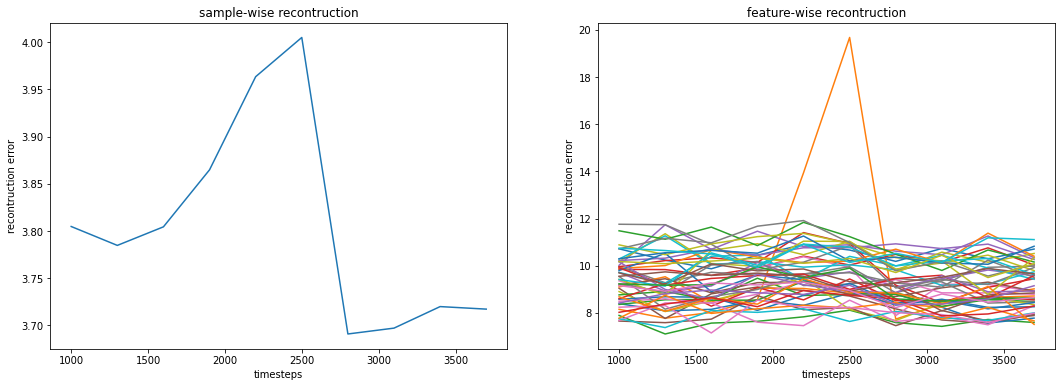

In [7]:
### PLOT PCA RECONSTRUCTION ERRORS ###

plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
plt.plot(list(rec_errors_samples.keys()), 
         [np.mean(r) for r in rec_errors_samples.values()])
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('sample-wise recontruction')

plt.subplot(1,2,2)
for i in range(n_features):
    rec = []
    for r in rec_errors_features.values():
        rec.append(r[i])
    plt.plot(list(rec_errors_features.keys()), rec)
plt.ylabel('recontruction error'); plt.xlabel('timesteps')
plt.title('feature-wise recontruction')

plt.show()

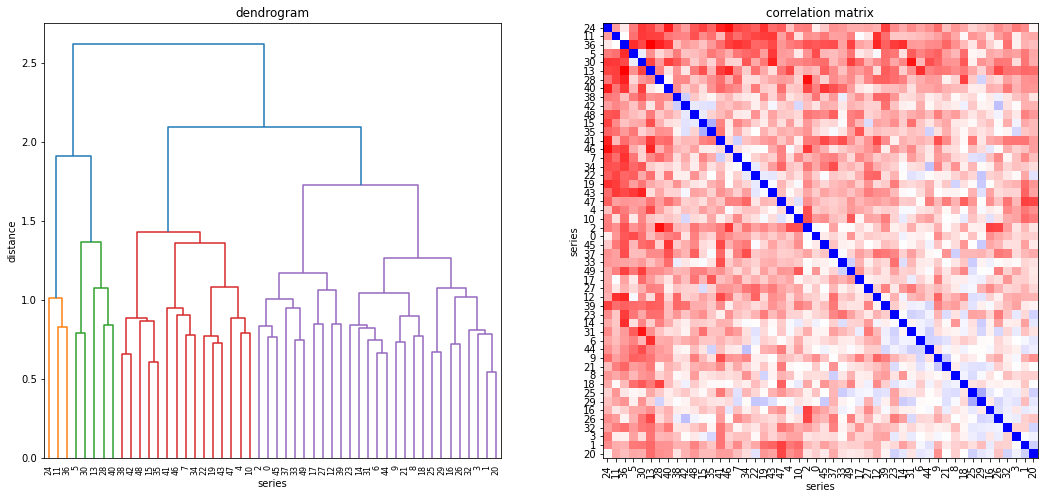

In [8]:
### COMPUTE HIERARCHICAL CLUSTERING ON CORRELATION MATRIX ###

d = sch.distance.pdist(corr_mat)
L = sch.linkage(d, method='ward')
ind = sch.fcluster(L, d.max(), 'distance')
dendrogram = sch.dendrogram(L, no_plot=True)

labels = dendrogram['leaves']
corr_mat_cluster = pairwise_distances(
    pd.concat([X.iloc[:,[i]] for i in labels], axis=1).T,
    metric='correlation'
)

plt.figure(figsize=(18,8))
plt.subplot(1,2,1)
dendrogram = sch.dendrogram(L, no_plot=False)
plt.title('dendrogram')
plt.ylabel('distance'); plt.xlabel('series')
plt.subplot(1,2,2)
plt.imshow(corr_mat_cluster, cmap='bwr')
plt.title('correlation matrix')
plt.ylabel('series'); plt.xlabel('series')
plt.xticks(range(n_features), labels, rotation=90)
plt.yticks(range(n_features), labels)
plt.show()

In [9]:
### DBSCAN ANOMALY DETECTION ###

network_ano = {}
dbscan = DBSCAN(eps=0.6, min_samples=1, metric="precomputed")

for i, (past_id,_) in enumerate(
    TimeSeriesSplit(10, test_size=300, max_train_size=300).split(X)
):
    
    preds = dbscan.fit_predict(
        pairwise_distances(X.iloc[past_id].T, metric='correlation')
    )
    if (preds > 0).any():
        ano_features = list(X.columns[np.where(preds > 0)[0]])
        network_ano[past_id[-1]] = ano_features
    else:
        network_ano[past_id[-1]] = None

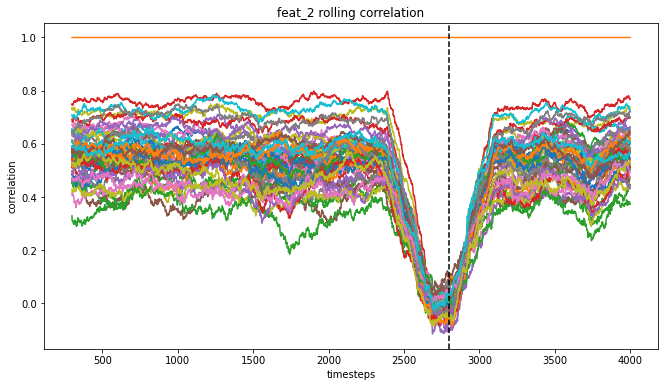

In [10]:
### PLOT DBSCAN DETECTED ANOMALIES ###

roll_corr = X.rolling(300).corr()

for ano_loc,ano in network_ano.items():
    if ano is not None:
        for ano_feat in network_ano[ano_loc]:
            roll_corr[ano_feat].unstack().plot(
                legend=False, figsize=(11,6),
                title=f"{ano_feat} rolling correlation",
                ylabel='correlation', xlabel='timesteps'
            )
            plt.axvline(ano_loc, linestyle='--', c='black')
            plt.show()